In [1]:
from SCA_classes import Segmentation_Collision_Avoidance, Debug_Timer, Config, timeit
import numba_functs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import cv2
import time
import yaml
import glob
from ultralytics import FastSAM
from collections import defaultdict
from shapely.geometry import Point, Polygon
from numba import njit, prange
from timeit import default_timer as timer
from PIL import Image
from scipy import stats

In [ ]:
sca = Segmentation_Collision_Avoidance("config")
# for i in range(10):
#     sca.add_CARLA_image_file("1080p" + str(i + 40))

for i in range(6):
    sca.add_OAKD_image_file(str(i + 73))
    fig = sca.plot2()
    # plt.savefig("figs/" + str(i) + ".jpg")
    # plt.close()

# for i in range(6): # 2, 6
#     sca.add_OAKD_image_file("2_" + str(i + 69))
#     fig = sca.plot()
#     plt.savefig("figs/" + str(i + 6) + ".jpg")
#     plt.close()

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# rgbImgs = sorted(glob.glob("../oakd_data/streetViewData_view1/rgb_video/*.png"))
# depthImgs = sorted(glob.glob("../oakd_data/streetViewData_view1/disparity/*.png"))
# sca.add_image_file(rgbImgs[7], depthImgs[7])
# depthImg = sca.window.current_frame.depthImg
# rgbImg = sca.window.current_frame.rgbImg

In [ ]:
# plt.imshow(depthImg)
# magic_trust_number = 8.45
# plt.figure()
# plt.imshow(np.where(depthImg > magic_trust_number, np.nan, depthImg))
# plt.figure()
# plt.imshow(rgbImg)

In [ ]:
# Debug_Timer.turn_off()
# sca = Segmentation_Collision_Avoidance("config")
# rgbImgs = sorted(glob.glob("../oakd_data/streetViewData_view2/rgb_video/*.png"))
# depthImgs = sorted(glob.glob("../oakd_data/streetViewData_view2/disparity/*.png"))
# print(len(rgbImgs))
# for i in range(len(rgbImgs)):
#     sca.add_image_file(rgbImgs[i], depthImgs[i])
#     fig = sca.plot2()
#     plt.savefig("figs/crosswalk_diagonal/" + "{:04d}".format(i) + ".jpg")
#     plt.close()
#     print(i)

In [ ]:
# frames = [Image.open(image) for image in sorted(glob.glob("figs/*.jpg"))]
# print(len(frames))
# frame_one = frames[0]
# frame_one.save("gifs/crosswalk_parallel.gif", format="GIF", append_images=frames[1:],
#             save_all=True, duration=100, loop=0)

In [ ]:
# for i in range(6): # 2, 6
#     sca.add_OAKD_image_file("2_" + str(i + 69))

for i in range(6):
    sca.add_OAKD_image_file(str(i + 73))
window = sca.window
frame = window.current_frame
plt.imshow(frame.rgbImg)
for obj in window.objects_in_scope:
    outline = np.concatenate((obj.outline, [obj.outline[0,:]]))
    plt.plot(outline[:,0],outline[:,1])

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


KeyboardInterrupt: 

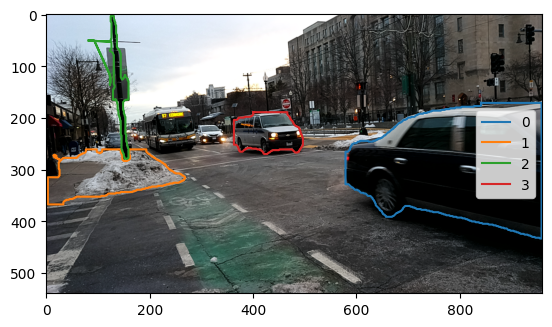

In [ ]:
plt.imshow(frame.rgbImg)
obj_list = window.objects_in_scope
num_obj = len(obj_list)
areas = np.empty(num_obj)
for i in range(num_obj):
    obj = obj_list[i]
    areas[i] = np.sum(obj.segMask)
argsort = areas.argsort()[::-1]
for i in range(num_obj):
    obj = obj_list[argsort[i]]
    outline = np.concatenate((obj.outline, [obj.outline[0,:]]))
    plt.plot(outline[:,0],outline[:,1],label=i)
plt.legend()

In [ ]:
# # plt.imshow(frame.rgbImg)
# obj_list = window.objects_in_scope
# num_obj = len(obj_list)
# areas = np.empty(num_obj)
# for i in range(num_obj):
#     obj = obj_list[i]
#     areas[i] = np.sum(obj.segMask)
# argsort = areas.argsort()[::-1] # largest to smallest
# grid = np.zeros(frame.rgbImg.shape[0:2], dtype=int) - 1
# for i in range(num_obj):
#     obj = obj_list[argsort[i]]
#     d = []
#     section = grid.flatten()[obj.segMask.flatten()]
#     for j in range(section.size):
#         if section[j] not in d:
#             d.append(section[j])
#     for idx in d:
#         if idx == -1:
#             continue
#         other_obj = obj_list[argsort[idx]]
#         if np.sum(np.logical_and(obj.segMask, other_obj.segMask)) / np.sum(obj.segMask) > Config.get("object_overlap_percent"):
#             other_obj.segMask = np.logical_or(obj.segMask, other_obj.segMask)
#             obj.set_out_of_scope()
#     grid[np.logical_and(grid == -1, obj.segMask)] = i
# plt.imshow(grid)
# plt.figure()
# # plt.imshow(frame.rgbImg)
# for obj in window.objects_in_scope:
#     if obj.in_scope:
#         plt.imshow(np.where(obj.segMask,0,np.nan))
# plt.figure()
# plt.imshow(frame.rgbImg)
# for obj in window.objects_in_scope:
#     if obj.in_scope:
#         outline = np.concatenate((obj.outline, [obj.outline[0,:]]))
#         plt.plot(outline[:,0],outline[:,1])

/tmp/ipykernel_3175461/901528872.py:14: RuntimeWarning: invalid value encountered in cast
  nan_rgbImg[:,:,i] = np.where(erase, np.nan, frame.rgbImg[:,:,i])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

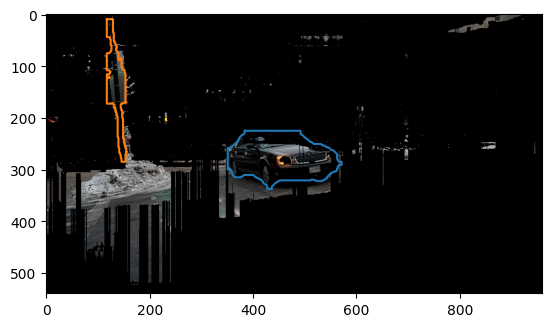

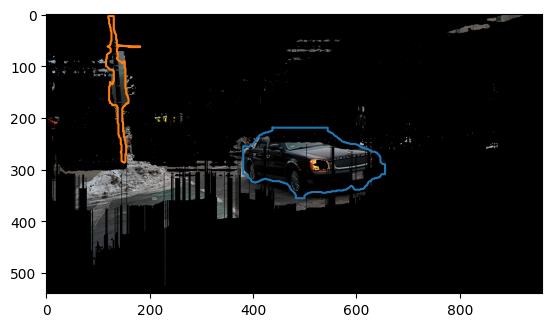

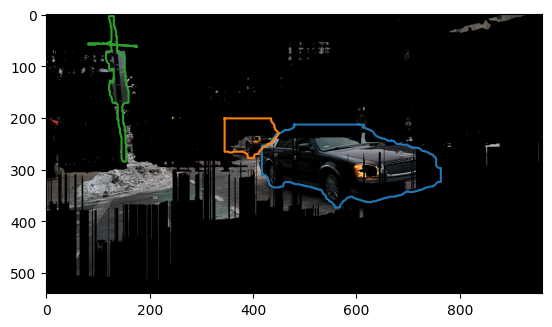

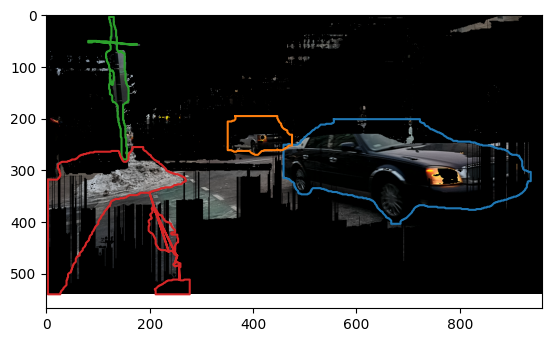

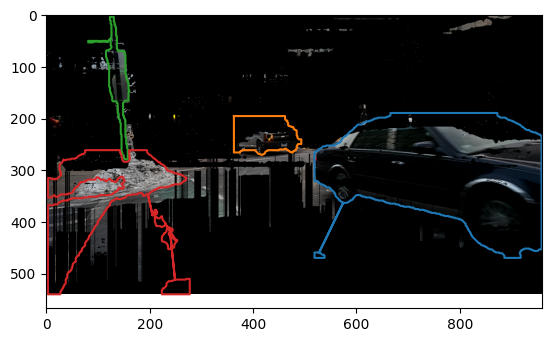

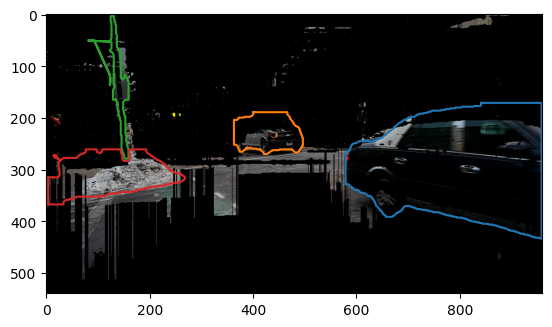

In [ ]:
sca = Segmentation_Collision_Avoidance("config")
for i in range(6):
    plt.figure()
    sca.add_OAKD_image_file(str(i + 73))
    window = sca.window
    frame = window.current_frame
    nan_rgbImg = np.zeros(frame.rgbImg.shape, dtype=int)
    # plt.imshow(frame.rgbImg)
    # plt.imshow(np.where(frame.sky == 0, np.nan, 0))
    # plt.imshow(np.where(frame.ground == 0, np.nan, 0))
    # plt.imshow(np.where(frame.low_confidence == 0, np.nan, 0))
    erase = frame.sky | frame.ground | frame.low_confidence
    for i in range(3):
        nan_rgbImg[:,:,i] = np.where(erase, np.nan, frame.rgbImg[:,:,i])
    plt.imshow(nan_rgbImg)
    # plt.imshow(erase, np.nan, frame.rgbImg)
    for obj in window.objects_in_scope:
        outline = np.concatenate((obj.outline, [obj.outline[0,:]]))
        plt.plot(outline[:,0],outline[:,1])

(np.float64(-4.940863131081749),
 np.float64(4.030979662565297),
 np.float64(2.1408923110996447),
 np.float64(9.661312041998414))

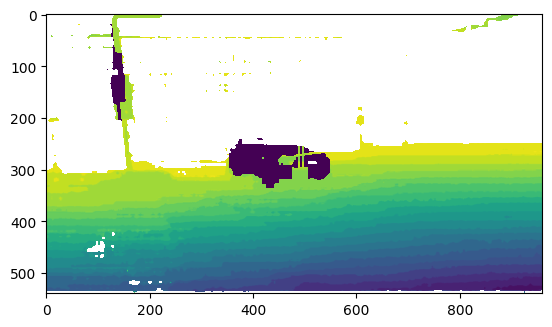

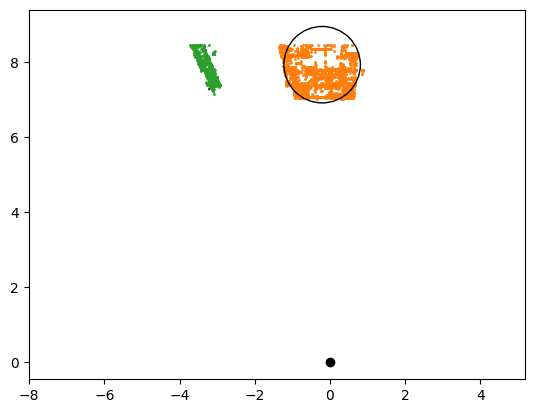

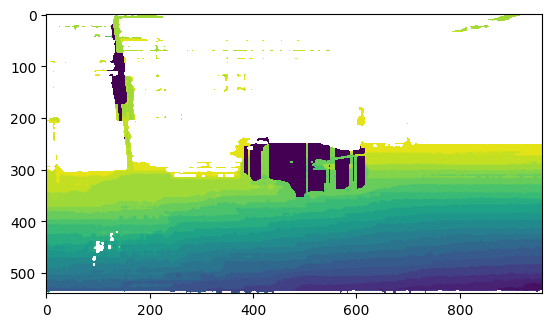

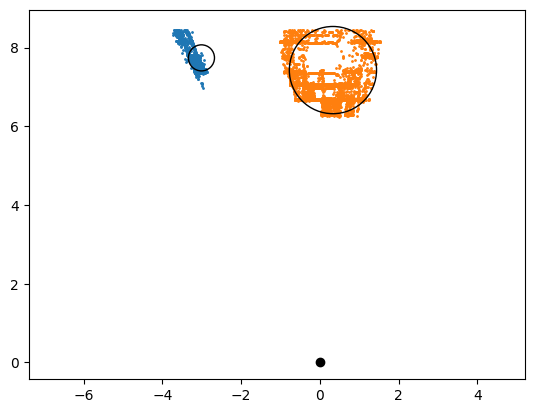

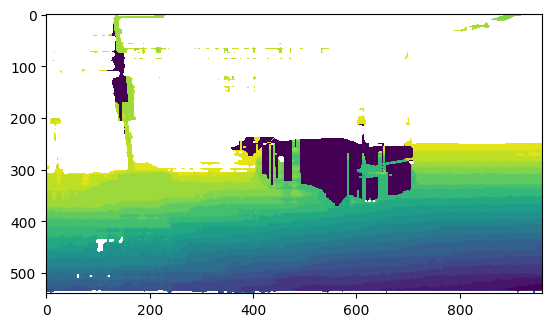

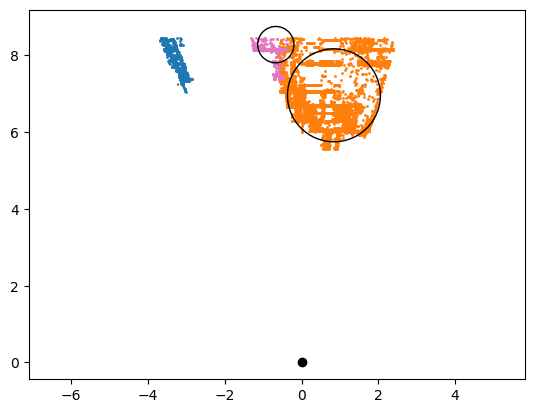

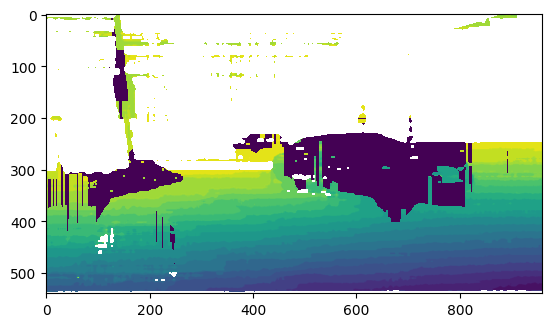

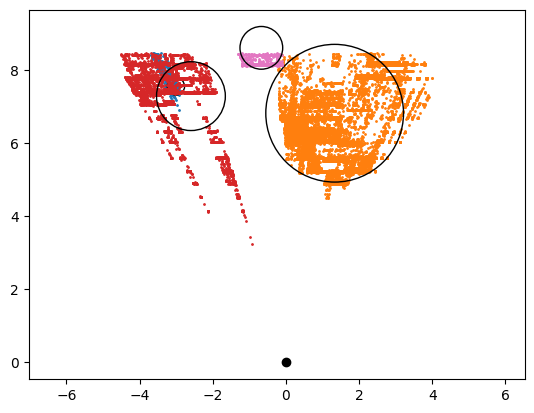

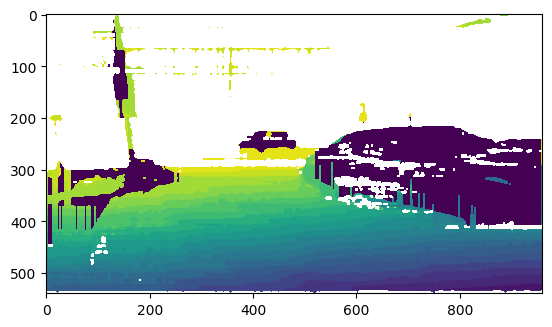

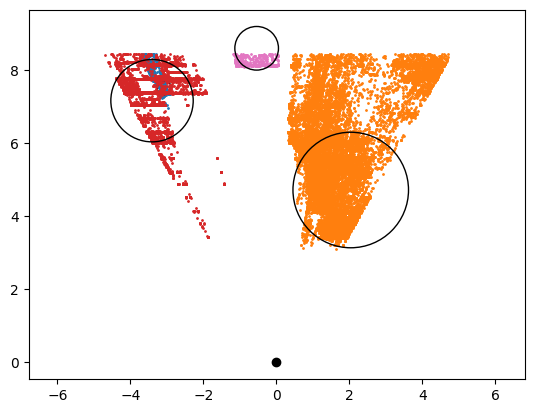

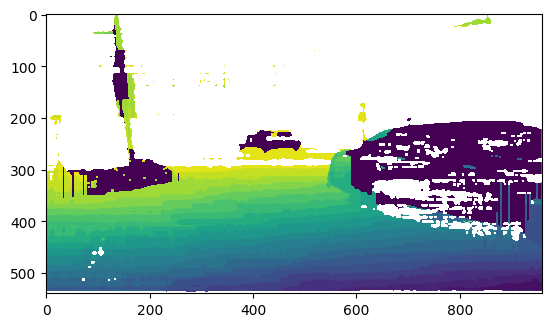

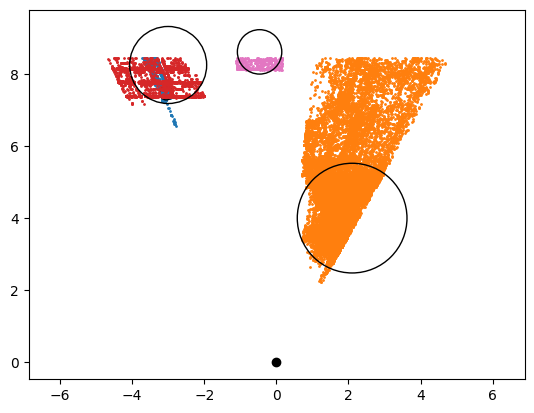

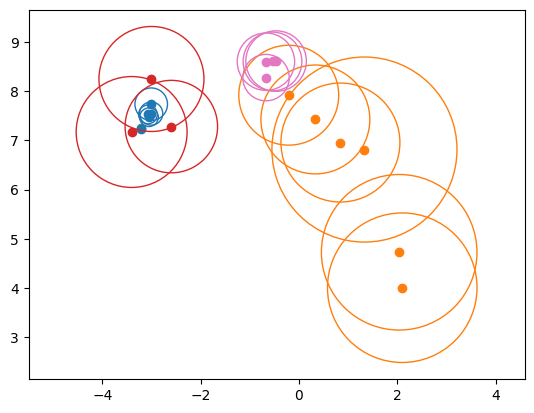

In [ ]:
sca = Segmentation_Collision_Avoidance("config")
plt.figure('track')
trax = plt.gcf().gca()
colors = list(mcolors.TABLEAU_COLORS.values())
for i in range(6):
    plt.figure()
    sca.add_OAKD_image_file(str(i + 73))
    window = sca.window
    frame = window.current_frame
    nan_depthImg = np.zeros(frame.depthImg.shape)
    # plt.imshow(frame.rgbImg)
    # plt.imshow(np.where(frame.sky == 0, np.nan, 0))
    # plt.imshow(np.where(frame.ground == 0, np.nan, 0))
    # plt.imshow(np.where(frame.low_confidence == 0, np.nan, 0))
    erase = frame.sky | frame.ground | frame.low_confidence
    # depthImg = np.where(erase, np.nan, frame.depthImg)
    nan_depthImg = np.where(frame.low_confidence, np.nan, frame.depthImg)
    plt.imshow(nan_depthImg)
    # plt.imshow(erase, np.nan, frame.rgbImg)
    for obj in window.objects_in_scope:
        mask = np.where(obj.segMask,0,np.nan)
        plt.imshow(mask)
    plt.figure()
    ax = plt.gcf().gca()
    plt.scatter(0,0,c='k')
    plt.axis('equal')
    for obj in window.objects_in_scope:
        mask = obj.segMask
        top_down = np.array([frame.cartImg[mask,0].flatten(), frame.cartImg[mask,2].flatten()]).T
        plt.scatter(top_down[:,0],top_down[:,1],s=1,c=colors[obj.id % len(colors)])
        circle = obj.circle
        show_fit_circle = plt.Circle((circle[0], circle[1]), circle[2], fill=False)
        ax.add_patch(show_fit_circle)
    # plt.figure('track')
    for obj in window.objects_in_scope:
        circle = obj.circle
        plt.figure('track')
        plt.scatter(circle[0], circle[1], color=colors[obj.id % len(colors)])
        show_fit_circle = plt.Circle((circle[0], circle[1]), circle[2], fill=False, color=colors[obj.id % len(colors)])
        trax.add_patch(show_fit_circle)
plt.figure('track')
plt.axis('equal')

/tmp/ipykernel_3175461/3617053719.py:10: RuntimeWarning: invalid value encountered in cast
  rgbImg[:,:,i] = np.where(obj.segMask, frame.rgbImg[:,:,i], np.nan)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9223372036854775808..248].


1
6
50
243


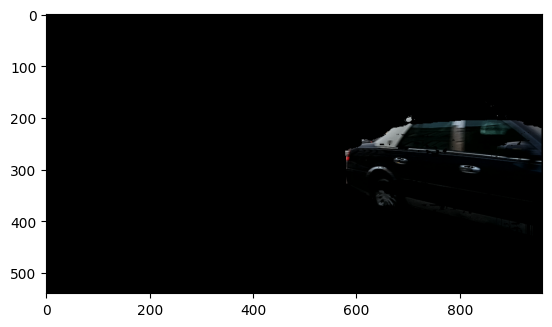

In [ ]:
obj_idx = 1
window = sca.window
frame = window.current_frame
for object in window.objects_in_scope:
    print(object.id)
    if object.id == obj_idx:
        obj = object
rgbImg = np.zeros(frame.rgbImg.shape, dtype=int)
for i in range(3):
    rgbImg[:,:,i] = np.where(obj.segMask, frame.rgbImg[:,:,i], np.nan)
plt.imshow(rgbImg)

In [ ]:
def fit_circle(obj, frame):
        mask = obj.segMask
        top_down = np.array([frame.cartImg[mask,0].flatten(), frame.cartImg[mask,2].flatten()]).T
        top_down = top_down[np.logical_not(np.isnan(top_down[:,0])),:]
        right_most = top_down[np.where(top_down[:,0] == np.nanmax(top_down[:,0]))[0][0], :]
        left_most = top_down[np.where(top_down[:,0] == np.nanmin(top_down[:,0]))[0][0], :]
        right_most_angle = math.atan(right_most[0] / right_most[1])
        left_most_angle = math.atan(left_most[0] / left_most[1])
        angle_from_straight = (right_most_angle + left_most_angle) / 2
        sin = math.sin(angle_from_straight)
        cos = math.cos(angle_from_straight)
        rm = np.array([[cos,sin],[-sin,cos]])
        rotated = np.matmul(top_down, rm)
        # find edge paralel to x axis
        h = np.max(rotated[:,1])
        d = rotated[:,0] * h / rotated[:,1]
        n = np.sqrt((d - rotated[:,0]) ** 2 + (h - rotated[:,1]) ** 2)
        iso = np.asarray([d, h - n]).T
        num_p = Config.get("number_edge_points")
        argsort = iso[:, 0].argsort()
        sorted_iso = iso[argsort]
        buckets = np.linspace(np.min(sorted_iso[:,0]), np.max(sorted_iso[:,0]), num_p)
        wheres = np.zeros(buckets.size - 1, dtype=int)
        buckets_i = 0
        last_bucket = 0
        for points_i in range(sorted_iso.shape[0]):
            if sorted_iso[points_i,0] > buckets[buckets_i + 1]:
                wheres[buckets_i] = np.where(sorted_iso[last_bucket:points_i,1]\
                    == np.min(sorted_iso[last_bucket:points_i,1]))[0][0] + last_bucket
                last_bucket = points_i
                buckets_i += 1
        try:
            wheres[-1] = np.where(sorted_iso[last_bucket:points_i,1]\
                == np.min(sorted_iso[last_bucket:points_i,1]))[0][0] + last_bucket
        except ValueError:
            wheres = wheres[:-1]
        to_fit = rotated[argsort[wheres],:] # TODO: fix bug where sometimes a value in wheres isn't set
        # fit a circle to the linear regression of the edge
        res = stats.linregress(to_fit[:,0], to_fit[:,1])
        ends = np.empty((2,2))
        ends[0,0] = to_fit[0,0]
        ends[1,0] = to_fit[-1,0]
        ends[0,1] = res.intercept + res.slope * to_fit[0,0]
        ends[1,1] = res.intercept + res.slope * to_fit[-1,0]
        midpoint = np.sum(ends, axis=0) / 2
        radius = math.sqrt((ends[0,0] - ends[1,0]) ** 2 + (ends[0,1] - ends[1,1]) ** 2) / 2
        s = radius * math.pi / 4
        theta = math.atan(-1 / res.slope)
        x = s * math.cos(theta)
        y = s * math.sin(theta)
        center = np.asarray([x * np.sign(y) + midpoint[0], y * np.sign(y) + midpoint[1]])
        fit_circle = np.array([center[0], center[1], radius]) # [x, y, radius]
        sin = math.sin(-angle_from_straight)
        cos = math.cos(-angle_from_straight)
        rm = np.array([[cos,sin],[-sin,cos]])
        fit_circle[0:2] = np.matmul(fit_circle[0:2], rm)
        obj.circle = fit_circle
        plt.figure()
        ax = plt.gcf().gca()
        plt.scatter(0,0,c='k')
        plt.scatter(top_down[:,0],top_down[:,1],c=frame.cartImg[mask,1], s=1)
        show_fit_circle = plt.Circle((fit_circle[0], fit_circle[1]), fit_circle[2], fill=False)
        ax.add_patch(show_fit_circle)
        plt.axis('equal')
        plt.figure()
        plt.scatter(0,0,c='k')
        plt.scatter(iso[:,0],iso[:,1],c=frame.cartImg[mask,1], s=1)
        plt.scatter(iso[argsort[wheres]][:,0],iso[argsort[wheres]][:,1],c='orange',s=1)
        plt.axis('equal')

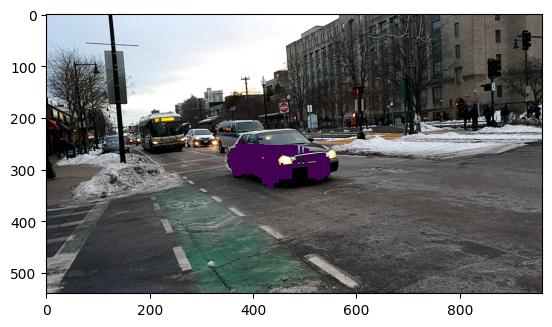

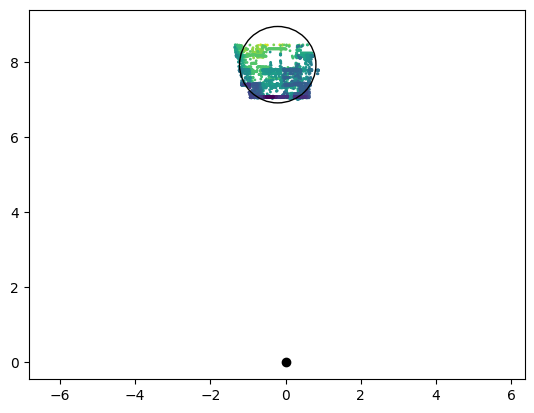

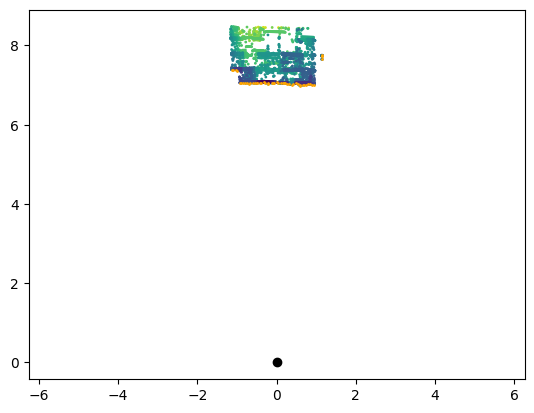

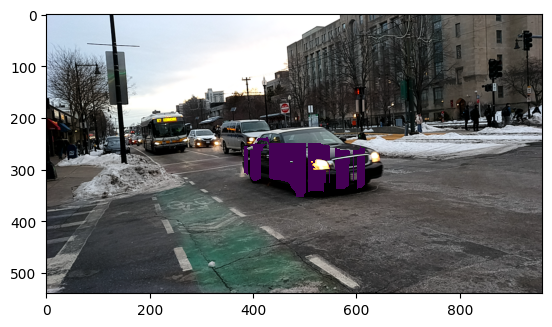

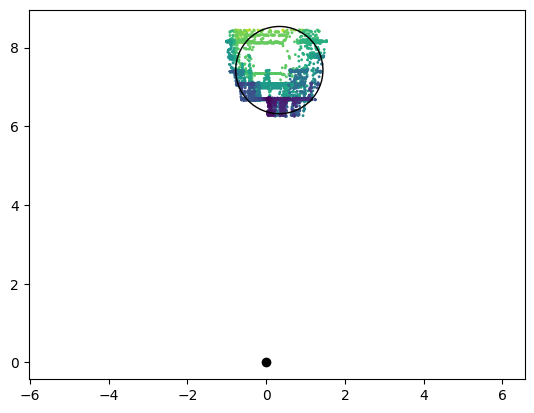

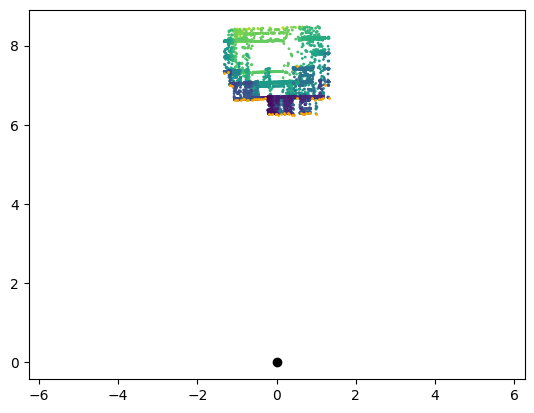

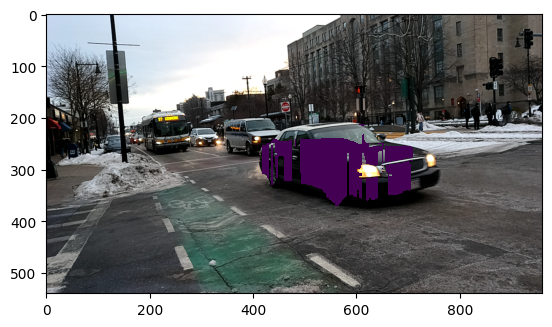

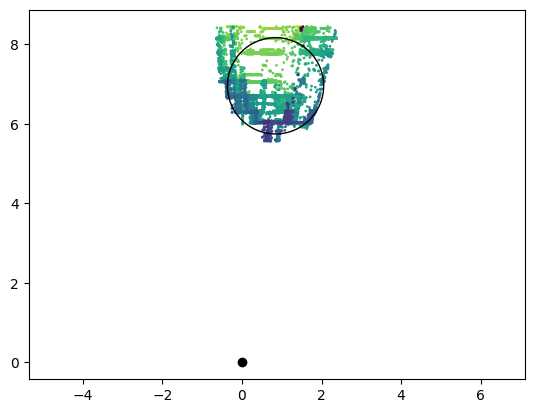

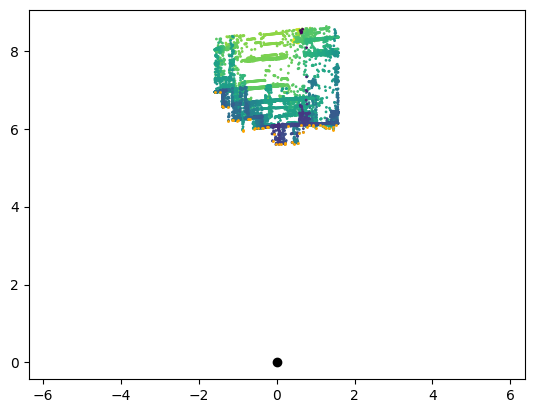

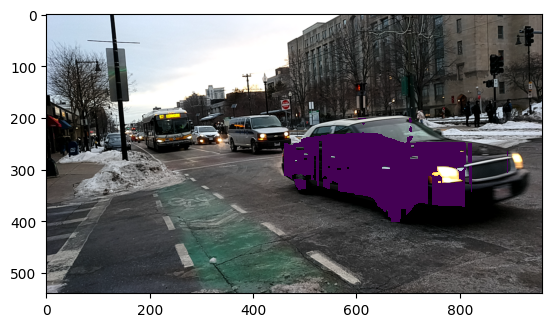

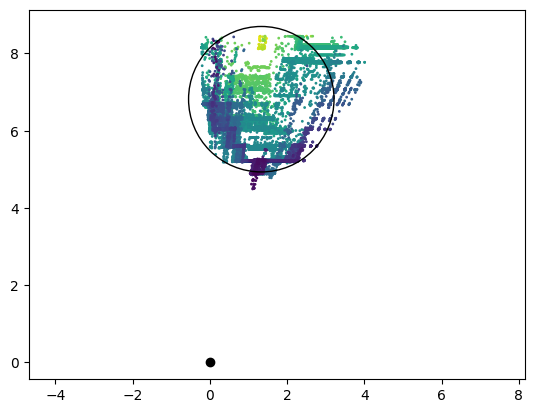

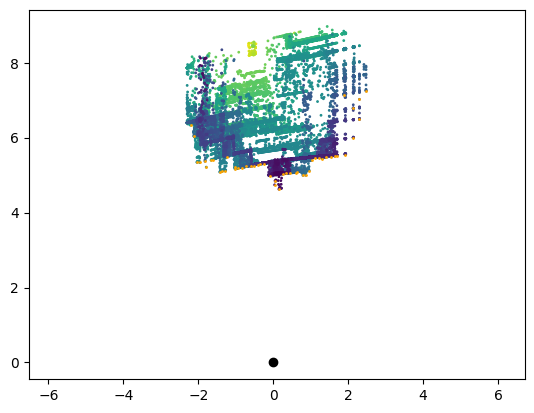

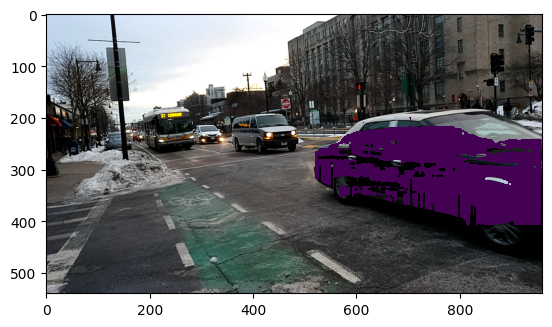

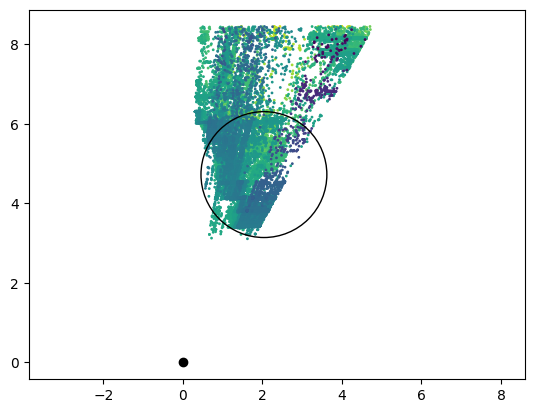

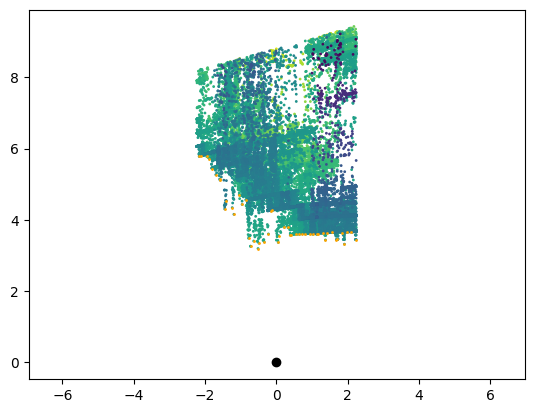

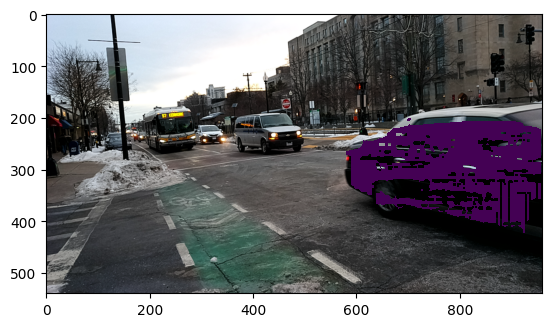

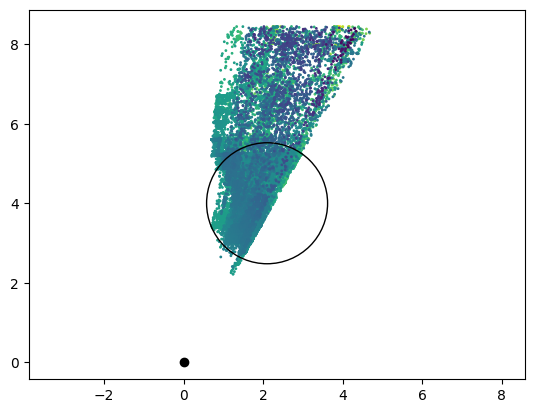

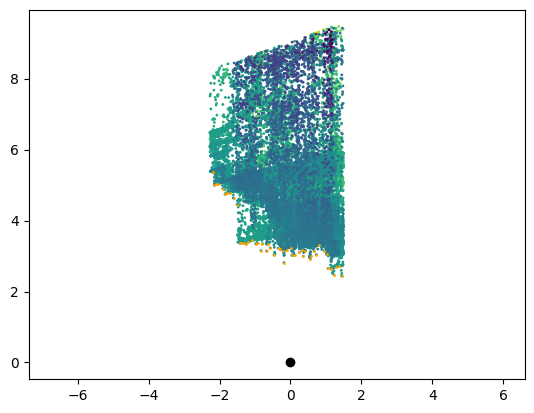

In [ ]:
sca = Segmentation_Collision_Avoidance("config")
for i in range(6):
    plt.figure()
    sca.add_OAKD_image_file(str(i + 73))
    plt.imshow(sca.window.current_frame.rgbImg)
    for object in sca.window.objects_in_scope:
        if object.id == obj_idx:
            plt.imshow(np.where(object.segMask,0,np.nan))            
            fit_circle(object, sca.window.current_frame)

In [ ]:
# SAVE!!!!

def get_ground(column, cartImg, draw=True):
    outline = np.asarray([cartImg[:,column,2], cartImg[:,column,1], np.zeros(cartImg[:,0,0].shape[0]) - 1]).T[::-1,:]
    outline_nanless = outline[np.logical_not(np.isnan(outline))[:,0],:]
    length = outline_nanless.shape[0]
    # if draw:
    start = np.where(np.min(outline_nanless[:,0]) == outline_nanless[:,0])[0][0]
    # Debug_Timer.start("put in buckets")
    lda = .25
    max_dist = 1#.4
    max_angle = .5
    curr_bucket = np.max(outline_nanless[:,0]) ** 2
    prev_bucket = np.max(outline_nanless[:,0]) ** 2
    bucket_i = -1
    buckets = np.zeros((length, 3)) # [x, y, total]
    for p_i in range(start, length):
        point = outline_nanless[p_i,0:2]
        if abs(point[0] - curr_bucket) < lda:
            outline_nanless[p_i,2] = bucket_i
            buckets[bucket_i, 0:2] += point
            buckets[bucket_i, 2] += 1
            curr_bucket = buckets[bucket_i, 0] / buckets[bucket_i, 2]
            continue
        if abs(point[0] - prev_bucket) < lda:
            outline_nanless[p_i,2] = bucket_i - 1
            buckets[bucket_i - 1, 0:2] += point
            buckets[bucket_i - 1, 2] += 1
            prev_bucket = buckets[bucket_i - 1, 0] / buckets[bucket_i - 1, 2]
            continue
        bucket_i += 1
        prev_bucket = curr_bucket
        curr_bucket = point[0]
        buckets[bucket_i, 2] += 1
        buckets[bucket_i, 0:2] += point
    buckets = buckets[:bucket_i + 1,0:2] / buckets[:bucket_i + 1,2].reshape(bucket_i + 1,1)
    # if draw:
    # Debug_Timer.stop("put in buckets")
    # Debug_Timer.start("find idx")
    dist = np.sum(np.square(buckets[:-1,:] - buckets[1:,:]), axis=1)
    angle = np.acos(abs(buckets[:-1,0] - buckets[1:,0]) ** 2 / dist)
    done = buckets.shape[0] - 1
    for i in range(buckets.shape[0] - 2):
        if draw:
            print(dist[i + 1], abs(angle[i] - angle[i + 1]))
        if dist[i + 1] > max_dist or abs(angle[i] - angle[i + 1]) > max_angle:
            done = i + 1
            break
    if done >= buckets.shape[0]:
        done = buckets.shape[0] - 1
    c = buckets[done]
    mini = np.max(outline_nanless[:,0]) - np.min(outline_nanless[:,0])
    for i in range(start, outline.shape[0]):
        dist = np.sum(np.square(c - outline[i,0:2]))
        if dist < mini:
            mini = dist
            idx = i
    if draw:
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(buckets.shape[0]):
            thing = outline_nanless[np.where(outline_nanless[:,2] == i)[0],:]
            plt.scatter(thing[:,0],thing[:,1],color=colors[i % len(colors)])
        plt.scatter(buckets[:,0],buckets[:,1],color='k',s=1)
        plt.scatter(outline[idx,0],outline[idx,1],color='w')
        model = np.poly1d(np.polyfit(outline_nanless[:,0], outline_nanless[:,1], 2))
        polyline = np.linspace(np.max(outline_nanless[:,0]), np.min(outline_nanless[:,0]), 50)
        plt.plot(polyline, model(polyline))
    # Debug_Timer.stop("find idx")
    return idx

# SAVE!!!!

In [ ]:
# ori_ground = np.zeros(frame.depthImg.shape, dtype=bool)
# cartImg = np.zeros(frame.cartImg.shape)
# for i in range(3):
#     cartImg[:,:,i] = np.where(frame.low_confidence, np.nan, frame.cartImg[:,:,i])
# length = frame.depthImg[:,0].shape[0]
# for i in range(cartImg.shape[1]):
#     idx = get_ground(i, cartImg, False)
#     ori_ground[length - idx:,i] = True
# plt.imshow(frame.ground)
# plt.figure()
# plt.imshow(ori_ground)
# plt.figure()
# ground = np.where(ori_ground, 0, np.nan)
# plt.imshow(ground)
# plt.figure()
# plt.imshow(frame.rgbImg)
# plt.imshow(ground)
# plt.figure()
# plt.imshow(frame.depthImg)
# plt.imshow(ground)
# plt.figure()
# plt.imshow(nan_rgbImg)
# plt.imshow(ground)
# plt.figure()
# plt.imshow(nan_depthImg)
# plt.imshow(ground)

In [ ]:
# column = 350
# cartImg = np.empty(frame.cartImg.shape)
# for i in range(3):
#     cartImg[:,:,i] = np.where(frame.low_confidence, np.nan, frame.cartImg[:,:,i])
# print(length - get_ground(column, cartImg))
# plt.figure()
# plt.imshow(nan_depthImg)
# plt.imshow(ground)
# plt.plot([column, column],[0,nan_depthImg.shape[0] - 1])
# plt.figure()
# a = column - 50
# e = column + 50
# # plt.imshow(nan_depthImg[200:,a:e])
# plt.imshow(ori_ground[200:,a:e])
# # plt.plot([50, 50],[0,nan_depthImg.shape[0] - 200 - 1])

In [ ]:
# outline = np.asarray([cartImg[:,column,2], cartImg[:,column,1], np.zeros(cartImg[:,0,0].shape[0]) - 1]).T[::-1,:]
# outline_nanless = outline[np.logical_not(np.isnan(outline))[:,0],:]
# plt.scatter(outline[:,0],outline[:,1],c=np.linspace(0,1,outline.shape[0]))
# plt.figure()
# plt.plot(outline_nanless[:,0],outline_nanless[:,1])
# plt.figure()
# sorted = outline_nanless[outline_nanless[:,0].argsort(),:]
# plt.plot(sorted[:,0],sorted[:,1])

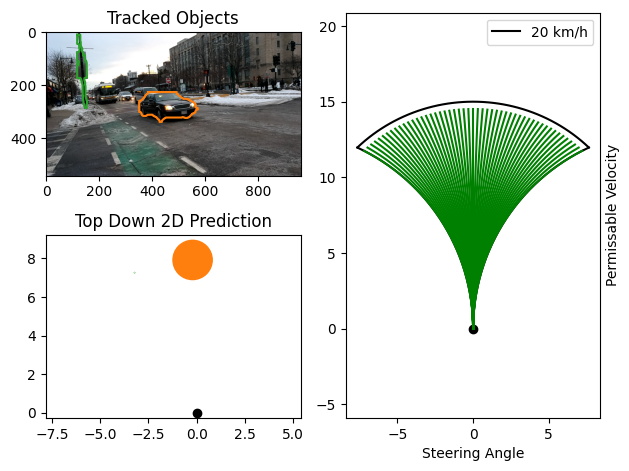

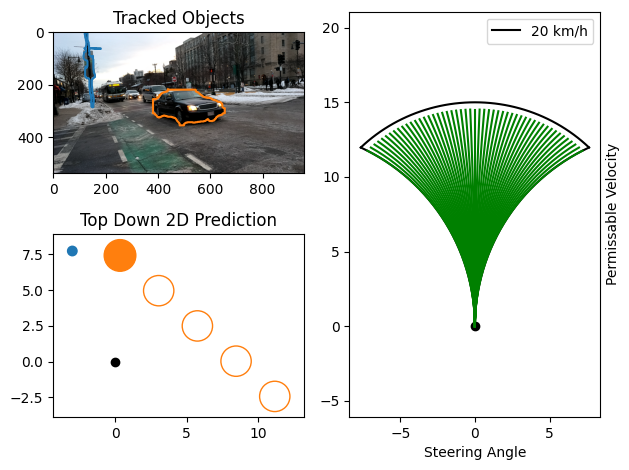

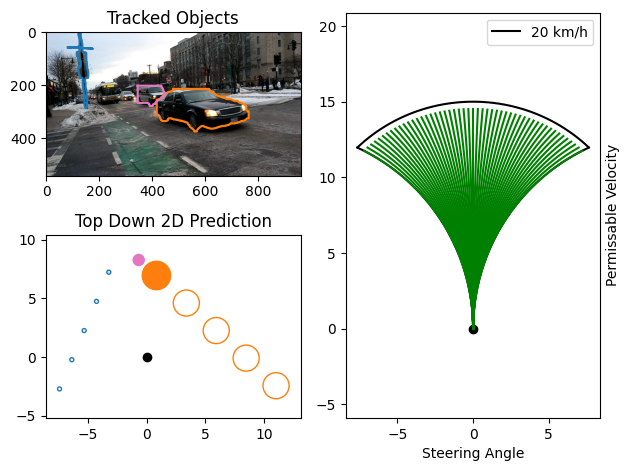

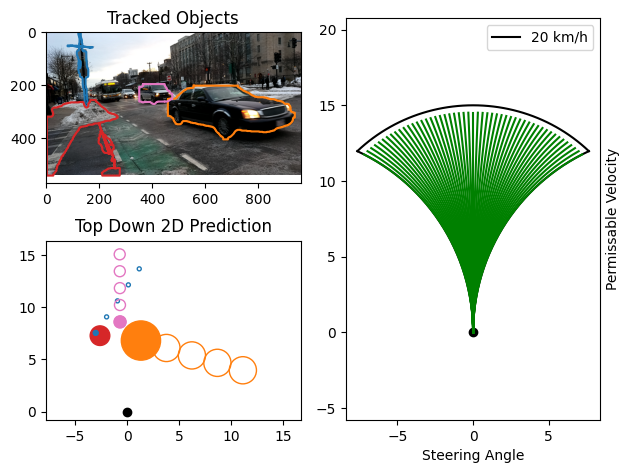

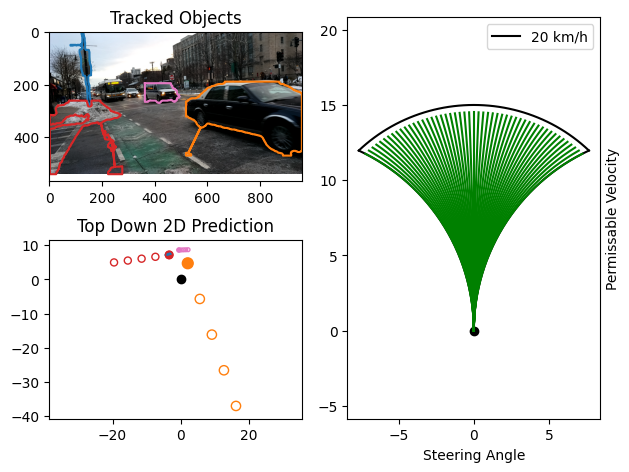

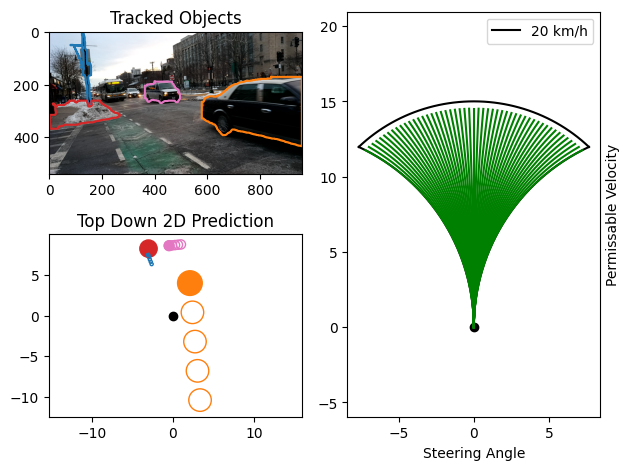

In [ ]:
# sca = Segmentation_Collision_Avoidance("config")
# # for i in range(10):
# #     sca.add_CARLA_image_file("1080p" + str(i + 40))

# for i in range(6):
#     sca.add_OAKD_image_file(str(i + 73))
#     fig = sca.plot2()
#     # plt.savefig("figs/" + str(i) + ".jpg")
#     # plt.close()

# # for i in range(6): # 2, 6
# #     sca.add_OAKD_image_file("2_" + str(i + 69))
# #     fig = sca.plot()
# #     plt.savefig("figs/" + str(i + 6) + ".jpg")
# #     plt.close()

In [ ]:
Debug_Timer.print_all()

add_OAKD_image_file:
	total = 104.45833267085254, 30 samples
	avg = 3.4819444223617513, min = 3.396633238065988, max = 4.28030750900507
filter_objects:
	total = 79.21623496059328, 30 samples
	avg = 2.6405411653531092, min = 2.593293434008956, max = 2.687746366020292
find_ground:
	total = 75.1489934423007, 30 samples
	avg = 2.5049664480766904, min = 2.4691630792804062, max = 2.5553744342178106
make_cartesian:
	total = 13.85808259760961, 30 samples
	avg = 0.461936086586987, min = 0.4529827400110662, max = 0.47442472307011485
fastSAM:
	total = 5.443728293292224, 30 samples
	avg = 0.18145760977640749, min = 0.1367797190323472, max = 0.9087925548665226
fit_circle:
	total = 0.5672908537089825, 95 samples
	avg = 0.005971482670620868, min = 0.0023799119517207146, max = 0.030072323977947235
consolidate_objects:
	total = 0.4831740241497755, 30 samples
	avg = 0.016105800804992517, min = 0.011765114963054657, max = 0.01966423401609063
open_img:
	total = 0.36869646050035954, 30 samples
	avg = 0.012

In [ ]:
# window = sca.window
# frame = window.current_frame

In [ ]:
# plt.imshow(frame.rgbImg)
# plt.figure()
# plt.imshow(frame.depthImg)
# # [vertical, horizontal]